A feature cross is a synthetic feature, created by multiplying two or more features.

This helps in learning highly complex models.

A feature cross is a synthetic feature that encodes non linearity into feature space by multiplying two or more features.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [11]:
california_housing_dataframe = pd.read_csv('https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv', sep=',')

california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12063,-121.4,38.5,36.0,1581.0,288.0,832.0,291.0,3.4,71800.0
11651,-121.3,38.0,48.0,1778.0,541.0,1237.0,462.0,1.3,103100.0
2775,-117.7,33.5,21.0,2208.0,534.0,1423.0,482.0,3.6,305600.0
6625,-118.3,34.0,23.0,1983.0,611.0,2048.0,600.0,1.5,91400.0
9857,-119.7,36.7,18.0,8099.0,1670.0,4476.0,1514.0,2.5,88300.0


In [0]:
def preprocess_features(cfd):

  selected_features = cfd[["latitude","longitude","housing_median_age","total_rooms", "total_bedrooms","population","households","median_income"]]

  processed_features = selected_features.copy()

  processed_features['rooms_per_person'] = cfd['total_rooms'] / cfd['population']

  return processed_features

In [0]:
def preprocess_targets(cfd):

  target = pd.DataFrame()
  target['median_house_value'] = cfd['median_house_value'] / 1000.0

  return target

In [0]:
training_example = preprocess_features(california_housing_dataframe.head(12000))
training_target = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

In [0]:
def creating_feature_column(input_feature):

  return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_feature])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, epochs=None):

  features = {key:np.array(value) for key,value in dict(features).items()}

  ds = Dataset.from_tensor_slices((features, targets))
  ds = ds.batch(batch_size).repeat(epochs)

  if shuffle:
    ds = ds.shuffle(10000)

  feature, target = ds.make_one_shot_iterator().get_next()

  return feature, target

In [0]:
def train_model(learning_rate, steps, batch_size, feature_columns, training_example, training_target, validation_example, validation_targets):

  periods = 10
  steps_per_period = steps / periods

  my_optimizer = tf.train.FtrlOptimizer(learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=my_optimizer)

  training_input_fn = lambda: my_input_fn(training_example, training_target['median_house_value'], batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_example, training_target['median_house_value'],shuffle=False, epochs=1)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets['median_house_value'], shuffle=False, epochs=1)

  print('training begins')
  print('RMSE on training data')
  training_RMSE = []
  validation_RMSE = []
  for period in range(periods):


    linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)

    prediction_training = linear_regressor.predict(predict_training_input_fn)
    prediction_training = np.array([item['predictions'][0] for item in prediction_training])

    prediction_validation = linear_regressor.predict(predict_validation_input_fn)
    prediction_validation = np.array([item['predictions'][0] for item in prediction_validation])

    rmse_training = math.sqrt(metrics.mean_squared_error(prediction_training, training_target))
    print("  period %02d training rmse : %0.2f" % (period, rmse_training))

    rmse_validation = math.sqrt(metrics.mean_squared_error(prediction_validation, validation_targets))
    print("  period %02d validation rmse : %0.2f" % (period, rmse_validation))

    training_RMSE.append(rmse_training)
    validation_RMSE.append(rmse_validation)

  print('training complete')

  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_RMSE, label="training")
  plt.plot(validation_RMSE, label="validation")
  plt.legend()

  return linear_regressor

training begins
RMSE on training data
  period 00 training rmse : 188.24
  period 00 validation rmse : 189.68
  period 01 training rmse : 175.19
  period 01 validation rmse : 176.82
  period 02 training rmse : 168.25
  period 02 validation rmse : 170.14
  period 03 training rmse : 165.67
  period 03 validation rmse : 167.75
  period 04 training rmse : 164.31
  period 04 validation rmse : 166.62
  period 05 training rmse : 164.07
  period 05 validation rmse : 166.57
  period 06 training rmse : 164.12
  period 06 validation rmse : 166.68
  period 07 training rmse : 164.48
  period 07 validation rmse : 167.17
  period 08 training rmse : 165.06
  period 08 validation rmse : 167.86
  period 09 training rmse : 165.41
  period 09 validation rmse : 168.26
training complete


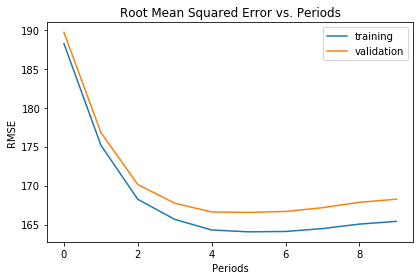

In [18]:
linear_regressor = train_model(0.001, 500, 5, creating_feature_column(training_example), training_example, training_target, validation_examples, validation_targets)

In [0]:
def get_quantiled_based_boundaries(feature_values, num_buckets):

  boundaries = np.arange(1.0, num_buckets) / num_buckets
  quantiles = feature_values.quantile(boundaries)

  return [quantiles[q] for q in quantiles.keys()] 

In [20]:
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12063,-121.4,38.5,36.0,1581.0,288.0,832.0,291.0,3.4,71800.0
11651,-121.3,38.0,48.0,1778.0,541.0,1237.0,462.0,1.3,103100.0
2775,-117.7,33.5,21.0,2208.0,534.0,1423.0,482.0,3.6,305600.0
6625,-118.3,34.0,23.0,1983.0,611.0,2048.0,600.0,1.5,91400.0
9857,-119.7,36.7,18.0,8099.0,1670.0,4476.0,1514.0,2.5,88300.0


In [0]:
def construct_feature_colums():
  '''
  constructs feature column based on bucketized feature columns
  '''

  households = tf.feature_column.numeric_column('households')
  longitude = tf.feature_column.numeric_column('longitude')
  latitude = tf.feature_column.numeric_column('latitude')
  housing_median_age = tf.feature_column.numeric_column('housing_median_age')
  median_income	= tf.feature_column.numeric_column('median_income')
  rooms_per_person = tf.feature_column.numeric_column('rooms_per_person')

  # create bucketized columns based on boundaries
  bucketized_households = tf.feature_column.bucketized_column(households, boundaries=get_quantiled_based_boundaries(training_example['households'], 7))
  bucketized_longitude = tf.feature_column.bucketized_column(longitude, boundaries=get_quantiled_based_boundaries(training_example['longitude'], 10))
  bucketized_latitude = tf.feature_column.bucketized_column(latitude, get_quantiled_based_boundaries(training_example['latitude'], 10))
  bucketized_houseing_median_age = tf.feature_column.bucketized_column(housing_median_age, get_quantiled_based_boundaries(training_example['housing_median_age'], 7))
  bucketized_median_income = tf.feature_column.bucketized_column(median_income, get_quantiled_based_boundaries(training_example['median_income'], 7))
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(rooms_per_person, get_quantiled_based_boundaries(training_example['rooms_per_person'], 7))

  feature_columns = set([bucketized_longitude, bucketized_latitude, bucketized_houseing_median_age, bucketized_households, bucketized_median_income, bucketized_rooms_per_person])

  return feature_columns  

training begins
RMSE on training data
  period 00 training rmse : 169.35
  period 00 validation rmse : 170.40
  period 01 training rmse : 143.24
  period 01 validation rmse : 143.90
  period 02 training rmse : 126.91
  period 02 validation rmse : 127.23
  period 03 training rmse : 115.84
  period 03 validation rmse : 115.88
  period 04 training rmse : 107.94
  period 04 validation rmse : 107.76
  period 05 training rmse : 102.17
  period 05 validation rmse : 101.87
  period 06 training rmse : 97.70
  period 06 validation rmse : 97.33
  period 07 training rmse : 94.15
  period 07 validation rmse : 93.77
  period 08 training rmse : 91.21
  period 08 validation rmse : 90.83
  period 09 training rmse : 88.72
  period 09 validation rmse : 88.36
training complete


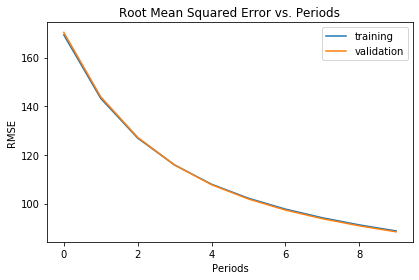

In [31]:
linear_regressor = train_model(1.0, 500, 100, construct_feature_colums(), training_example, training_target, validation_examples, validation_targets)

In [0]:
def construct_feature_colums_cross_feature():
  '''
  constructs feature column based on bucketized feature columns
  '''

  households = tf.feature_column.numeric_column('households')
  longitude = tf.feature_column.numeric_column('longitude')
  latitude = tf.feature_column.numeric_column('latitude')
  housing_median_age = tf.feature_column.numeric_column('housing_median_age')
  median_income	= tf.feature_column.numeric_column('median_income')
  rooms_per_person = tf.feature_column.numeric_column('rooms_per_person')

  # create bucketized columns based on boundaries
  bucketized_households = tf.feature_column.bucketized_column(households, boundaries=get_quantiled_based_boundaries(training_example['households'], 7))
  bucketized_longitude = tf.feature_column.bucketized_column(longitude, boundaries=get_quantiled_based_boundaries(training_example['longitude'], 10))
  bucketized_latitude = tf.feature_column.bucketized_column(latitude, get_quantiled_based_boundaries(training_example['latitude'], 10))
  bucketized_houseing_median_age = tf.feature_column.bucketized_column(housing_median_age, get_quantiled_based_boundaries(training_example['housing_median_age'], 7))
  bucketized_median_income = tf.feature_column.bucketized_column(median_income, get_quantiled_based_boundaries(training_example['median_income'], 7))
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(rooms_per_person, get_quantiled_based_boundaries(training_example['rooms_per_person'], 7))
  long_x_lat = tf.feature_column.crossed_column(set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

  feature_columns = set([bucketized_longitude, bucketized_latitude, bucketized_houseing_median_age, bucketized_households, bucketized_median_income, bucketized_rooms_per_person, long_x_lat])

  return feature_columns  

training begins
RMSE on training data
  period 00 training rmse : 163.08
  period 00 validation rmse : 164.05
  period 01 training rmse : 134.91
  period 01 validation rmse : 135.39
  period 02 training rmse : 117.89
  period 02 validation rmse : 117.94
  period 03 training rmse : 106.70
  period 03 validation rmse : 106.48
  period 04 training rmse : 98.82
  period 04 validation rmse : 98.45
  period 05 training rmse : 92.86
  period 05 validation rmse : 92.45
  period 06 training rmse : 88.39
  period 06 validation rmse : 87.97
  period 07 training rmse : 84.82
  period 07 validation rmse : 84.46
  period 08 training rmse : 81.87
  period 08 validation rmse : 81.56
  period 09 training rmse : 79.52
  period 09 validation rmse : 79.28
training complete


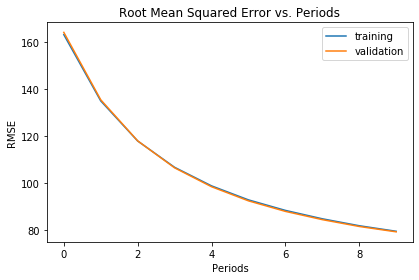

In [34]:
linear_regressor = train_model(1.0, 500, 100, construct_feature_colums_cross_feature(), training_example, training_target, validation_examples, validation_targets)